<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [30]:
import pandas as pd
df = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


### Fit a Gensim LDA topic model on Amazon Reviews

In [31]:
# loading NLP library and tokenizer
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

# Define the tokenize function
tokens = []

for doc in tokenizer.pipe(df['reviews.text'], batch_size=500):
    doc_tokens = []
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.lemma_.lower())
    tokens.append(doc_tokens)

df['tokens'] = tokens
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality., miss, backup, ..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, product, like]"
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[duracell, price, happy.]"
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, battery, well, price]"
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[battery, long, last, price, great.]"


In [32]:
from gensim import corpora

# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(df['tokens'])
print(len(id2word))

19476


In [33]:
# Remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)
print(len(id2word))

4883


In [34]:
# a bag of words(bow) representation of our corpus
corpus = [id2word.doc2bow(text) for text in df['tokens']]

### Evaluate Number of Topics

In [35]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    for iter_ in range(passes):
        print(f"=== Pass {iter_ + 1} of {passes} ===")
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12, passes=5)
            print(f"Model with {num_topics} topics completed.")
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
        print('\n')
    return coherence_values

In [37]:
coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus,
                                            start=2, 
                                            limit=50, 
                                            step=2,
                                            passes=10)

=== Pass 1 of 10 ===
Model with 2 topics completed.
Model with 4 topics completed.
Model with 6 topics completed.
Model with 8 topics completed.
Model with 10 topics completed.
Model with 12 topics completed.
Model with 14 topics completed.
Model with 16 topics completed.
Model with 18 topics completed.
Model with 20 topics completed.
Model with 22 topics completed.
Model with 24 topics completed.
Model with 26 topics completed.
Model with 28 topics completed.
Model with 30 topics completed.
Model with 32 topics completed.
Model with 34 topics completed.
Model with 36 topics completed.
Model with 38 topics completed.
Model with 40 topics completed.
Model with 42 topics completed.
Model with 44 topics completed.
Model with 46 topics completed.
Model with 48 topics completed.


=== Pass 2 of 10 ===
Model with 2 topics completed.
Model with 4 topics completed.
Model with 6 topics completed.
Model with 8 topics completed.
Model with 10 topics completed.
Model with 12 topics completed.
Mode

In [38]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.356652
1,0,4,-2.442197
2,0,6,-2.388180
3,0,8,-2.441711
4,0,10,-2.545886


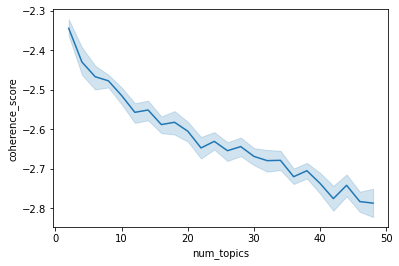

In [39]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [40]:
# LDA
# Chose 8 topics

from gensim.models.ldamulticore import LdaMulticore

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 8,
                   passes=100,
                   workers=12
                  )

In [41]:
import re

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
easy use use. set love

------ Topic 1 ------
great good price tablet product

------ Topic 2 ------
love year old it. buy

------ Topic 3 ------
battery long batteries. brand buy

------ Topic 4 ------
read great book tablet watch

------ Topic 5 ------
kindle fire love buy new

------ Topic 6 ------
work tablet works great kid

------ Topic 7 ------
tablet amazon app good it's



In [ ]:
# Steps to score new documents
"""
1. Tokenize Them (Same way you did training data)
2. Create the bag of words representations
3. Create the corpus object (Steps 2&3 pretty mush same thing)
4. Loop of the new doc and score them using lda[doc]
"""

In [47]:
# Steps to Score Training Documents
# Already have BOW Represented called 'corpus'
distro = [lda[d] for d in corpus]
num_topics = 8
def update(doc):
        d_dist = {k:0 for k in range(0,num_topics)}
        for topic in doc:
            # Topic is Tuple where the first part is the topic id
            # the second part is the topic distribution in that doc
            d_dist[topic[0]] = topic[1]
        return d_dist
new_distro = [update(d) for d in distro]

In [48]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.196615 -0.155049       1        1  24.812868
2     -0.197472  0.059092       2        1  14.480342
5     -0.059041 -0.214763       3        1  13.789860
7      0.039938 -0.013724       4        1  11.843050
1      0.216926  0.206781       5        1  10.171488
0     -0.185986  0.083057       6        1   9.344767
4     -0.023067 -0.005556       7        1   9.242351
6      0.012088  0.040163       8        1   6.315277, topic_info=         Term         Freq        Total Category  logprob  loglift
3     battery  6859.000000  6859.000000  Default  30.0000  30.0000
35       easy  3134.000000  3134.000000  Default  29.0000  29.0000
92       love  5719.000000  5719.000000  Default  28.0000  28.0000
71      great  7663.000000  7663.000000  Default  27.0000  27.0000
62       good  4675.000000  4675.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
198       far   118.716431   781.152588   Topic8  -5.1587   0.8782
1912      app   128.027878  1768.988892   Topic8  -5.0832   0.1363
117     don't   117.294960  1335.347168   Topic8  -5.1708   0.3299
31        buy   133.443573  4518.992188   Topic8  -5.0418  -0.7602
344      come   107.845497  1021.853760   Topic8  -5.2548   0.5135

[586 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
3643      5  0.978690   1st
144       1  0.241726     2
144       2  0.585184     2
144       3  0.100864     2
144       4  0.010434     2
...     ...       ...   ...
152       1  0.997339  xbox
2410      2  0.981959  xmas
106       2  0.999327  year
1171      8  0.959025  yet,
3696      2  0.998096    yr

[1154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 8, 2, 1, 5, 7])

In [49]:
# Are certain topics more helpful?
df['reviews.numHelpful'].describe()

count    16115.000000
mean         0.529321
std          9.345017
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        621.000000
Name: reviews.numHelpful, dtype: float64

In [50]:
# Continous Variable
# Bin - using boxplot of upvotes per topic

topics_df = pd.DataFrame(new_distro)
topics_df.columns = topics
topics_df.head()

,easy use use. set love,great good price tablet product,love year old it. buy,battery long batteries. brand buy,read great book tablet watch,kindle fire love buy new,work tablet works great kid,tablet amazon app good it's
0,0.011373,0.133913,0.011388,0.797794,0.011390,0.011376,0.011379,0.011386
1,0.020863,0.309994,0.020842,0.564877,0.020865,0.020857,0.020839,0.020862
2,0.031260,0.508475,0.031260,0.303777,0.031276,0.031283,0.031409,0.031261
3,0.020834,0.020905,0.020836,0.854013,0.020847,0.020851,0.020869,0.020846
4,0.020849,0.020875,0.020835,0.853987,0.020852,0.020844,0.020918,0.020840


In [51]:
topics_df['primaryTopic'] = topics_df.idxmax(axis=1)

In [52]:
topics_df['primaryTopic'].value_counts()

battery long batteries. brand buy    7651
great good price tablet product      4675
love year old it. buy                4475
kindle fire love buy new             2617
easy use use. set love               2557
tablet amazon app good it's          2496
read great book tablet watch         2074
work tablet works great kid          1787
Name: primaryTopic, dtype: int64

In [53]:
topics_df['numHelpful'] = df['reviews.numHelpful']

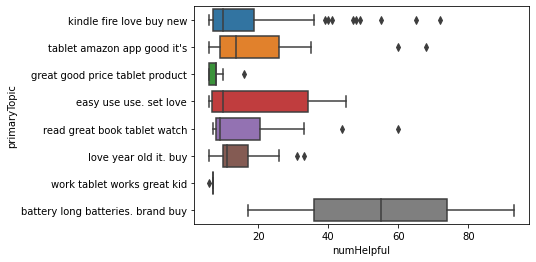

In [56]:
sns.boxplot(x="numHelpful", y="primaryTopic", data=topics_df[(topics_df['numHelpful']>5) & (topics_df['numHelpful']<100)]);

In [57]:
# Which topics has the gighest total number of helpful upvotes?

# Group by with two columns primaryTopic & Upvote
sample = topics_df[['primaryTopic', 'numHelpful']]
sample.groupby('primaryTopic').mean().sort_values(by='numHelpful', ascending=False)

,numHelpful
primaryTopic,
battery long batteries. brand buy,2.033333
kindle fire love buy new,1.473474
tablet amazon app good it's,0.878788
work tablet works great kid,0.423204
read great book tablet watch,0.348261
great good price tablet product,0.145161
easy use use. set love,0.128893
love year old it. buy,0.128217


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling